In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# 그래디언트 부스팅

## step1. 데이터 구성하기

In [2]:
df_raw = pd.read_csv("HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
df_raw["JOB"].fillna("Other", inplace=True)
df_raw.fillna(df_raw.mean(), inplace=True)

In [5]:
df_raw.isnull().sum(axis=0)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

#### 더미변수 생성

In [6]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [8]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.3, random_state =1234)
print("train data X size: {}".format(df_train_x.shape))

train data X size: (2623, 18)


## step2. 모델 생성

In [9]:
#  그래디언트 부스팅 모델 생성 : GradientBoostingClassifier
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x,df_train_y)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set: 0.963
Accuracy on test set: 0.941


In [10]:
gb_uncustomized

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### step2 모델 Parameter 조정
- 모델 파라미터 조정 : learning_rate

In [41]:
# train 및 test 정확도 결과 저장용
train_accuracy =[]; test_accuracy=[]
# learning_rate 학습률 변경 : 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1,10)] # para_lr: [0.1,0.2,0.3,...0,9]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate=v_learning_rate, random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [52]:
# LearningRate별 정확도 테이블
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937


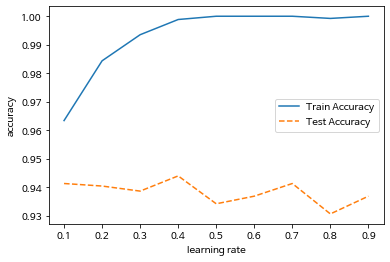

In [53]:
# LearningRate별 정확도 그래프로 확인
plt.plot(para_lr, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy");
plt.xlabel("learning rate");
plt.legend()

In [11]:
# 학습률 지정
learning_rate=0.1

### 모델 파라미터 조정 : n_estimators

In [12]:
# train 및 test 정확도 결과 저장용
train_accuracy =[]; test_accuracy=[]
# n_estimators: 트리수 변경 10~150
para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators=v_n_estimators, learning_rate=0.1, random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))

#데이터 테이블 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [13]:
# n_estimator별 정확도 테이블
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.940
7,80,0.960,0.940
8,90,0.961,0.940
9,100,0.963,0.941


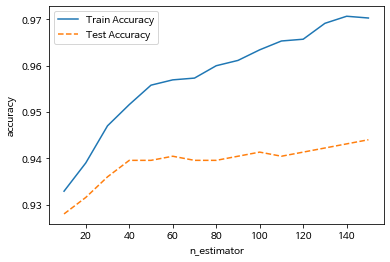

In [14]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("n_estimator")
plt.legend()

In [18]:
# 트리 수 지정
n_estimators =  100

### 모델 파라미터 조정 : max_depth

In [15]:
# train 및 test 정확도 결과 저장용
train_accuracy =[]; test_accuracy=[]
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = ㅊ, n_estimators=100, learning_rate=0.1, random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))

# 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [16]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.992,0.941
5,6,0.998,0.949
6,7,1.000,0.946
7,8,1.000,0.948
8,9,1.000,0.948
9,10,1.000,0.947


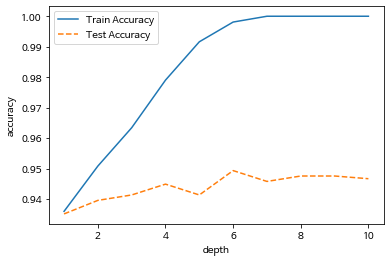

In [17]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("depth")
plt.legend()

In [19]:
# 최대 깊이 지정
max_depth = 4

### 모델 파라미터 조정 : min_samples_split

In [30]:
train_accuracy =[]; test_accuracy=[]
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수
para_split = [n_split*10 for n_split in range(2,11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split=v_min_samples_split, max_depth = 4, n_estimators=100, learning_rate=0.1, random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))

df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [31]:
# min_samples_split별 테이블
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.976,0.942
1,30,0.974,0.942
2,40,0.973,0.937
3,50,0.969,0.941
4,60,0.973,0.941
5,70,0.969,0.943
6,80,0.968,0.943
7,90,0.966,0.941
8,100,0.963,0.940


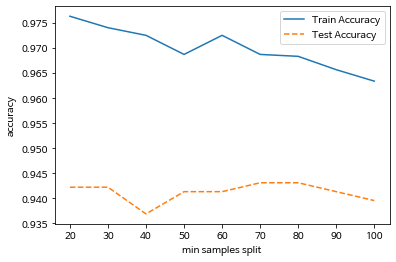

In [32]:
# 모델 정확도 그래프 확인
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("min samples split")
plt.legend()

### 모델 파라미터 조정 : min_samples_leaf

In [20]:
train_accuracy =[]; test_accuracy=[]
# min_samples_leaf: 잎사귀 노드 최소 자료 수 제한
para_leaf = [n_leaf*10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf=v_min_samples_leaf, max_depth = 4, n_estimators=100, learning_rate=0.1, random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [21]:
# min_samples_leaf별 정확도 테이블
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.977,0.946
1,20,0.970,0.942
2,30,0.970,0.942
3,40,0.963,0.940
4,50,0.960,0.942
5,60,0.958,0.939
6,70,0.958,0.937
7,80,0.955,0.940
8,90,0.950,0.936
9,100,0.948,0.938


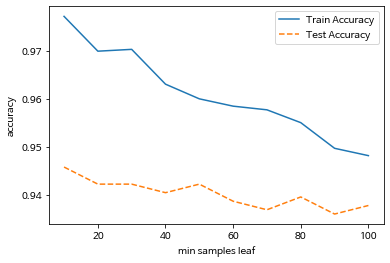

In [26]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("min samples leaf")
plt.legend()

## step3. 결론 도출

In [36]:
# 최종모델
gb_final = GradientBoostingClassifier(min_samples_leaf=10, max_depth = 4, n_estimators = 100, learning_rate=0.1, random_state=1234)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)

#train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(gb_final.score(df_train_x, df_train_y)))
#test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
#confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.977

Accuracy on test set: 0.946

Confusion matrix: 
[[1018    3]
 [  58   46]]


### feature_importance_: 설면변수의 중요도

In [37]:
#변수명
v_feature_name = df_train_x.columns

# tree.teature_importances_로 설명 변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = gb_final.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("importance", ascending=False, inplace=True)

In [38]:
df_importance.round(3)

,Feature,importance
9,DEBTINC,0.327
6,CLAGE,0.120
2,VALUE,0.107
8,CLNO,0.105
5,DELINQ,0.100
0,LOAN,0.072
1,MORTDUE,0.041
7,NINQ,0.038
4,DEROG,0.034
3,YOJ,0.033


Text(0, 0.5, '설명변수')

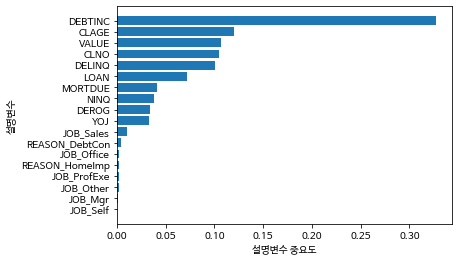

In [39]:
#설명변수 중요도 그래프
#중요도가 높은 변수를 상위에 그림.
df_importance.sort_values("importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

In [42]:
estimator = GradientBoostingClassifier(n_estimators=100, random_state=1234)
#구하고자 하는 parameter와 범위
param_grid = {"learning_rate":para_lr, 
              "max_depth":para_depth, 
              "min_samples_leaf":para_leaf}

#정확도가 높은 최적 parameter 찾기
grid_gb= GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs=-1)
grid_gb.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter:\n{}".format(grid_gb.best_params_))
print("\nbest score:\n{}".format(grid_gb.best_score_.round(3)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best estimator model: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

best parameter:
{'learning_rate': 0.4, 'max_depth': 6, 'min_samples_leaf': 10}

best score:
0.95
